##Importation of the libraries

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Graded essays dataset (train and test)

In [ ]:
import csv
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


##LOADING ROBERTA MODEL AND TOKENIZER

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Loop for the Model " Roberta"

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.7280286646658374
Epoch 2, Loss: 0.29568985633311734
Epoch 3, Loss: 0.2639483177373486
Epoch 4, Loss: 0.24867458281017119
Epoch 5, Loss: 0.2265312193382171
Epoch 6, Loss: 0.21138876412184007
Epoch 7, Loss: 0.19887372394723277
Epoch 8, Loss: 0.18651180065447284
Epoch 9, Loss: 0.16651313223185077
Epoch 10, Loss: 0.15736975977497716


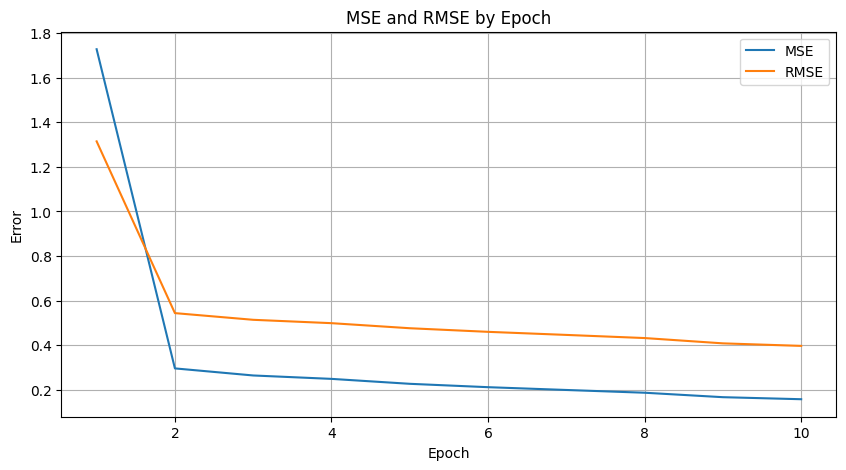

Metrics saved to /content/drive/MyDrive/model_metrics.npy


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length
        self.target_columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

        # Drop NaNs
        self.data.dropna(subset=self.target_columns, inplace=True)

        # Convert target columns to float, and handle possible conversion issues
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors='coerce')
        self.data.dropna(subset=self.target_columns, inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['full_text']
        targets = self.data.iloc[idx][self.target_columns].tolist()

        # Tokenize text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(targets, dtype=torch.float)
        }

# Load tokenizer and initialize dataset
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_df.dropna(subset=['full_text'], inplace=True)  # Ensure no NaNs in 'full_text'
train_dataset = CustomDataset(train_df, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the model
class RobertaRegressionModel(nn.Module):
    def __init__(self):
        super(RobertaRegressionModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.regressor = nn.Linear(self.roberta.config.hidden_size, 6)  # 6 target features

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_output)



import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaRegressionModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

# Storage for plot data
epoch_count = 10
mse = []
rmse = []

# Training loop
model.train()
for epoch in range(epoch_count):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {average_loss}')
    mse.append(average_loss)
    rmse.append(np.sqrt(average_loss))

# Plotting MSE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch_count+1), mse, label='MSE')
plt.plot(range(1, epoch_count+1), rmse, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('MSE and RMSE by Epoch')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/model_performance_metrics.png')
plt.show()

# Saving the metrics to a file
metrics_path = '/content/drive/MyDrive/model_metrics.npy'
np.save(metrics_path, np.array([mse, rmse]))
print(f"Metrics saved to {metrics_path}")



In [ ]:
 #Save the model weights to a file
torch.save(model.state_dict(), '/content/drive/MyDrive/roberta_regression_model_weights.pt')